# In this notebook we will be trying the transformer architecture
This choice is motivated by the fact that the transformer excels at seqtoseq, and is able to capture dependencies spatially and temporally. I hypothesize that this is a good fit for the task since ECOG data is very complex and has dependencies in both time and space.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import math
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
import matplotlib.pyplot as plt



## Data Processing

In [2]:
def calculate_vectors(coords, resolution):
    """
    Calculate the average vectors of x and y magnitudes given a resolution.

    Parameters:
    coords (list of tuples): An array of (x, y) coordinates.
    resolution (int): The resolution number.

    Returns:
    list of tuples: An array of vectors of x and y magnitudes.
    """
    if resolution <= 0:
        raise ValueError("Resolution must be a positive integer.")
    
    n = len(coords)
    if resolution > n:
        raise ValueError("Resolution cannot be greater than the length of the coordinates array.")
    
    # Calculate the segment length
    segment_length = n // resolution
    
    vectors = []
    
    for i in range(0, n, segment_length):
        segment = coords[i:i + segment_length]
        if len(segment) < segment_length:
            break
        
        # Calculate the average change in x and y
        delta_x = np.mean([segment[j+1][0] - segment[j][0] for j in range(len(segment) - 1)])
        delta_y = np.mean([segment[j+1][1] - segment[j][1] for j in range(len(segment) - 1)])
        
        vectors.append((delta_x, delta_y))
    
    return vectors

In [3]:
def vectorize_joystick_readings(x, y, resolution):
     return calculate_vectors(list(zip(x, y)), resolution)

    

In [4]:
def ica(X, n_components):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    return S_, A_

In [5]:
def normalize_data(d1):
    scaler = StandardScaler()
    d1 = scaler.fit_transform(d1)
    return d1

def train_test_split(X, y, train_size):
    train_size = int(train_size * len(X))
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

def chunk_data(data, length):
    chunk_size = length
    return [data[i:i+chunk_size] for i in range(0, len(data), len(data)//chunk_size) if i+chunk_size <= len(data)]

        

In [6]:
def load_process_joystick_data():
    # Load data from file
    fname = './data/joystick_track.npz'
    alldat = np.load(fname, allow_pickle=True)['dat']
    dat = alldat[0]
    patient_idx = 1
    d = dat[patient_idx]
    
    # Extract ECoG data and joystick vectors
    ecog_data = d['V']
    targetX = d['targetX']
    targetY = d['targetY']
    
    print(ecog_data.shape, targetX.shape, targetY.shape )
    # Normalize and PCA
    ecog_data = normalize_data(ecog_data)
    ecog_data = PCA(n_components=0.95).fit_transform(ecog_data)
    print(ecog_data.shape, targetX.shape, targetY.shape )
    # Set resolution and vectorize joystick readings
    resolution = 700
    targetX, targetY = normalize_data(targetX), normalize_data(targetY)
    vectors = np.array(vectorize_joystick_readings(targetX, targetY, resolution))
    print(ecog_data.shape, vectors.shape)
    # Chunk ECoG data based on resolution
    chunked_ecog_data = chunk_data(ecog_data, len(vectors))
    # Remove data points with zero vectors
    ecog_data, vectors = zip(*[(x, y) for x, y in zip(ecog_data, vectors) if not np.array_equal(y, [0, 0])])
    print(len(ecog_data), len(ecog_data[0]), len(vectors))
    print(len(chunked_ecog_data), len(chunked_ecog_data[0]), len(chunked_ecog_data[0][0]))
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(chunked_ecog_data, vectors, train_size=0.8)
    
    # Convert data back to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    return X_train, X_test, y_train, y_test


In [7]:
X_train, X_test, y_train, y_test = load_process_joystick_data()
min_len = min(len(X_test), len(y_test))
X_test = X_test[:min_len]
y_test = y_test[:min_len]
# reshape input to be [time steps, batch size, features]

print(X_train.shape, y_train.shape)

(248640, 64) (248640, 1) (248640, 1)
(248640, 28) (248640, 1) (248640, 1)
(248640, 28) (700, 2)
679 28 679
699 700 28
(559, 700, 28) (559, 2)


## 


## Data Augmentation

## Transfromers: robots in disguise

In [8]:
print(torch.cuda.is_available())
torch.set_default_device('cuda') if torch.cuda.is_available() else torch.set_default_device('cpu')


True


In [9]:
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
#print all shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train, y_train)

torch.Size([559, 700, 28]) torch.Size([120, 700, 28]) torch.Size([559, 2]) torch.Size([120, 2])
tensor([[[-3.5636e+00, -2.2142e-01,  3.5455e-01,  ..., -4.0250e-01,
           3.7540e-01, -4.1878e-01],
         [-4.2145e+00, -2.3734e-01,  3.7031e-01,  ..., -2.9681e-01,
           3.7048e-01, -3.8401e-01],
         [-4.5517e+00, -2.5918e-01,  3.8189e-01,  ..., -1.7190e-01,
           3.6903e-01, -3.3763e-01],
         ...,
         [ 6.4868e+00,  1.6992e+00, -2.0743e+00,  ...,  5.2482e-01,
          -1.9219e-01, -2.8105e-01],
         [ 6.2328e+00,  1.7402e+00, -2.0340e+00,  ...,  5.7298e-01,
          -2.0215e-01, -3.0032e-01],
         [ 6.2450e+00,  1.7968e+00, -1.9920e+00,  ...,  6.2103e-01,
          -2.0591e-01, -3.0314e-01]],

        [[-3.5565e+00, -4.3673e-01,  4.1906e-01,  ...,  4.6836e-02,
          -7.1411e-02,  2.5605e-01],
         [-2.9171e+00, -3.2429e-01,  3.5420e-01,  ...,  4.7743e-02,
          -1.0004e-01,  2.7177e-01],
         [-2.2750e+00, -2.2674e-01,  2.8591e-01,

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=6000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class ECoGTransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout_rate=0.1):
        super(ECoGTransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(model_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        x = checkpoint(self.transformer_encoder, x)
        x = x.permute(1, 0, 2)
        x = self.fc(x[:, -1, :])
        return x


In [12]:
# new loss
class ScaledMSELoss(nn.Module):
    def __init__(self, scale_factor):
        super(ScaledMSELoss, self).__init__()
        self.scale_factor = scale_factor
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        return self.mse_loss(input, target) * self.scale_factor

# Example usage
scale_factor = 1000  # Adjust the scale factor as needed

In [13]:
# Example hyperparameters
input_dim = X_train.shape[-1]
model_dim = 512
num_heads = 16
num_layers = 8
output_dim = 2 
dropout_rate = 0.3670812456459453
learning_rate = 1e-4
weight_decay = 1e-5

# Initialize the model
model = ECoGTransformerEncoder(input_dim, model_dim, num_heads, num_layers, output_dim)
# Ensure model parameters require gradients
for param in model.parameters():
    param.requires_grad = True
# Apply weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

# Training loop with mixed precision and gradient checkpointing
scaler = GradScaler()
criterion = ScaledMSELoss(scale_factor=scale_factor)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 1000
scheduler = StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)



c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


'model_dim': 128, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.3670812456459453, 'learning_rate': 0.0006976310761919828

In [14]:
# real data

input_tensor = X_train
target_tensor = y_train
dataset = TensorDataset(input_tensor, target_tensor)
generator = torch.Generator(device='cuda')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=generator)

In [15]:
print(f"Input mean: {input_tensor.mean()}, Input std: {input_tensor.std()}")
print(f"Target mean: {target_tensor.mean()}, Target std: {target_tensor.std()}")


Input mean: 0.0007466294919140637, Input std: 1.4338657855987549
Target mean: -4.670707483001024e-07, Target std: 0.0010870033875107765


In [16]:
print(X_train.shape, y_train.shape)
train = False
losses = []
# Early stopping parameters
patience = 20
best_loss = float('inf')
epochs_no_improve = 0
if train:
    model.train()
    for epoch in range(num_epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
                losses.append(loss.item())
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            #scheduler.step()
         # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in dataloader:
                with autocast():
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
        val_loss /= len(dataloader)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')
        if epoch%10 == 0:
            # loss direction as a magnitude of the last 10 losses
            print(f'Loss direction: {np.mean(losses[-10:]) - np.mean(losses[-20:-10])}')

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'\n\n---------------------------\n---------------------------\nEarly stopping at epoch {epoch+1}\n---------------------------\n---------------------------\n')
                break

    
    torch.save(model.state_dict(), 'transformer_model.pth')

torch.Size([559, 700, 28]) torch.Size([559, 2])


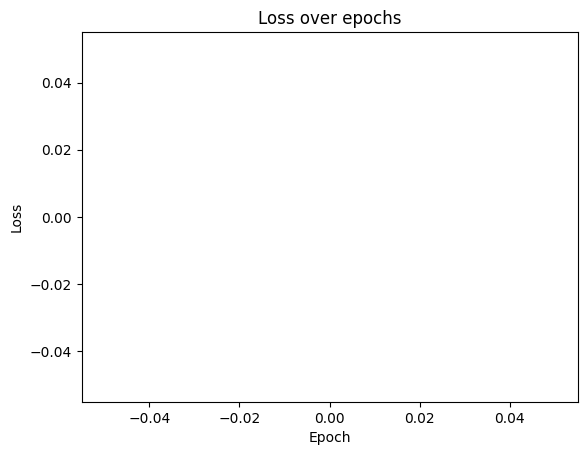

In [17]:
def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
plot_loss(losses)

# Model Testing

In [18]:
# test model
model.load_state_dict(torch.load('transformer_model.pth'))
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    loss = criterion(y_pred, y_test)
    print(f'Test Loss: {loss.item()}')
    y_test = y_test.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    # Plot the first 100 predictions
    plt.plot(y_test[:100, 0], label='True X')
    plt.plot(y_pred[:100, 0], label='Predicted X')
    plt.legend()
    plt.show()

    plt.plot(y_test[:100, 1], label='True Y')
    plt.plot(y_pred[:100, 1], label='Predicted Y')
    plt.legend()
    plt.show()

RuntimeError: Error(s) in loading state_dict for ECoGTransformerEncoder:
	Missing key(s) in state_dict: "transformer_encoder.layers.5.self_attn.in_proj_weight", "transformer_encoder.layers.5.self_attn.in_proj_bias", "transformer_encoder.layers.5.self_attn.out_proj.weight", "transformer_encoder.layers.5.self_attn.out_proj.bias", "transformer_encoder.layers.5.linear1.weight", "transformer_encoder.layers.5.linear1.bias", "transformer_encoder.layers.5.linear2.weight", "transformer_encoder.layers.5.linear2.bias", "transformer_encoder.layers.5.norm1.weight", "transformer_encoder.layers.5.norm1.bias", "transformer_encoder.layers.5.norm2.weight", "transformer_encoder.layers.5.norm2.bias", "transformer_encoder.layers.6.self_attn.in_proj_weight", "transformer_encoder.layers.6.self_attn.in_proj_bias", "transformer_encoder.layers.6.self_attn.out_proj.weight", "transformer_encoder.layers.6.self_attn.out_proj.bias", "transformer_encoder.layers.6.linear1.weight", "transformer_encoder.layers.6.linear1.bias", "transformer_encoder.layers.6.linear2.weight", "transformer_encoder.layers.6.linear2.bias", "transformer_encoder.layers.6.norm1.weight", "transformer_encoder.layers.6.norm1.bias", "transformer_encoder.layers.6.norm2.weight", "transformer_encoder.layers.6.norm2.bias", "transformer_encoder.layers.7.self_attn.in_proj_weight", "transformer_encoder.layers.7.self_attn.in_proj_bias", "transformer_encoder.layers.7.self_attn.out_proj.weight", "transformer_encoder.layers.7.self_attn.out_proj.bias", "transformer_encoder.layers.7.linear1.weight", "transformer_encoder.layers.7.linear1.bias", "transformer_encoder.layers.7.linear2.weight", "transformer_encoder.layers.7.linear2.bias", "transformer_encoder.layers.7.norm1.weight", "transformer_encoder.layers.7.norm1.bias", "transformer_encoder.layers.7.norm2.weight", "transformer_encoder.layers.7.norm2.bias". 

## Optuna, the hyperparameter optimizer

In [22]:
# run optuna?
run_optuna = True
import optuna
import torch
import torch.nn as nn



# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    model_dim = trial.suggest_categorical('model_dim', [128, 256, 512])
    num_heads = trial.suggest_categorical('num_heads', [4, 8, 16])
    num_layers = trial.suggest_int('num_layers', 4,8)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-4)
    
    # real data
    input_tensor = X_train
    target_tensor = y_train
    dataset = TensorDataset(input_tensor, target_tensor)
    generator = torch.Generator(device='cuda')
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=generator)
    
    # Model and optimizer
    model = ECoGTransformerEncoder(input_dim=X_train.shape[-1], model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, output_dim=2, dropout_rate=dropout_rate)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = ScaledMSELoss(1000)
    # Training loop
    print(trial.params)
    losses = []
    for epoch in range(100):
        for data, target in dataloader:
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
                losses.append(loss.item())
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            #scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    general_loss = np.mean(losses[-10:])
    return general_loss

if run_optuna:
    # Run the optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Best hyperparameters
    print(study.best_params)

[I 2024-07-23 12:34:41,322] A new study created in memory with name: no-name-06f5c844-abcc-404d-9567-db42eaa64bb5
C:\Users\thewa\AppData\Local\Temp\ipykernel_19348\1332823889.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\thewa\AppData\Local\Temp\ipykernel_19348\1332823889.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-4)


Epoch 1/1000, Loss: 410.1645202636719
Epoch 2/1000, Loss: 634.5203247070312
Epoch 3/1000, Loss: 500.87969970703125
Epoch 4/1000, Loss: 204.18307495117188
Epoch 5/1000, Loss: 269.0952453613281
Epoch 6/1000, Loss: 175.4502410888672
Epoch 7/1000, Loss: 201.57382202148438
Epoch 8/1000, Loss: 202.6818084716797
Epoch 9/1000, Loss: 109.95153045654297
Epoch 10/1000, Loss: 127.13128662109375
Epoch 11/1000, Loss: 69.03248596191406
Epoch 12/1000, Loss: 90.01192474365234
Epoch 13/1000, Loss: 134.20545959472656
Epoch 14/1000, Loss: 71.65036010742188
Epoch 15/1000, Loss: 57.88997268676758
Epoch 16/1000, Loss: 47.3446044921875
Epoch 17/1000, Loss: 52.556304931640625
Epoch 18/1000, Loss: 39.47270202636719
Epoch 19/1000, Loss: 34.48288345336914


best trial with output dim 1: [I 2024-07-22 11:58:14,634] Trial 15 finished with value: 753723.5625 and parameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 5, 'dropout_rate': 0.2259481444219587, 'learning_rate': 0.0009022268315380955}. Best is trial 15 with value: 753723.5625.

wrong output dim, trying 2.
best: {'model_dim': 512, 'num_heads': 8, 'num_layers': 6, 'dropout_rate': 0.48411131648232686, 'learning_rate': 0.0008203239127338236}

new optimization.
best: [I 2024-07-23 02:32:30,156] Trial 48 finished with value: 372409.4375 and parameters: {'model_dim': 128, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.3670812456459453, 'learning_rate': 0.0006976310761919828}. Best is trial 48 with value: 372409.4375.
